In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
args = {
    'num_clusters': 5,
    'num_eigen_vectors': 4,
    'sigma_color': 2,
    'sigma_distance': 3,
    'height': 30,
    'width': 30,
    'num_channels': 0,
    'num_dimensions': 0,
    'num_elements_flat': 0,
    'use_numpy_eigen_decompose': True,
    'dim_low': 600
}

# data_dir = os.path.join('..', 'data')
# image_dir = os.path.join(data_dir, 'idd20k_lite', 'leftImg8bit', 'train', '1')
# filename = '502201_image.jpg'
# image_path_full = os.path.join(image_dir, filename)
# image = cv2.imread(image_path_full)

# image = cv2.imread('bw.jpg')
image = cv2.imread('vegetables.png')


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # convert to Grayscale
image = cv2.resize(image, (args['height'], args['width']))



image_shape = len(image.shape)
if image_shape == 3:
    height, width, num_channels = image.shape
elif image_shape == 2:
    height, width = image.shape
    num_channels = 1
    
args['height'] = height
args['width'] = width
args['num_channels'] = num_channels
args['num_elements_flat'] = height * width
args['num_dimensions'] = num_channels + 2

In [3]:
def visualize_matrix(matrix, title=''):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(matrix)
    plt.colorbar()
    plt.show()
    
def imshow(image, title=''):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(image)
    plt.show()
    
def get_image_array(image):
    image_array = np.zeros((args['num_elements_flat'], (args['num_channels']+2)))

    image_array_index = 0
    for index_row in range(args['height']):
        for index_col in range(args['width']):
            current_pixel = image[index_row, index_col]
            image_array[image_array_index] = np.array([current_pixel[0], 
                                                       current_pixel[1], 
                                                       current_pixel[2], 
                                                       index_row, 
                                                       index_col])
            image_array_index += 1
    
    return image_array

def get_exponential_bump(distance, sigma=1):
    exponential_bump = np.exp(-np.abs(distance) / sigma**2)
    return exponential_bump
    
def get_eucledian_distance(point_1, point_2):
    euclidean_distance = np.sqrt(np.sum(np.power((point_1 - point_2), 2)))
    return euclidean_distance

def get_color_weight(point_1, point_2, sigma_color):
    difference_color = get_eucledian_distance(point_1, point_2)
    color_weight = get_exponential_bump(difference_color, sigma_color)
    return color_weight

def get_distance_weight(index_row_1, index_col_1, index_row_2, index_col_2, sigma_distance):
    point_1 = np.array([index_row_1, index_col_1])
    point_2 = np.array([index_row_2, index_col_2])
    distance = get_eucledian_distance(point_1, point_2)
    distance_weight = get_exponential_bump(distance, sigma_distance)
    return distance_weight

def get_weight_matrix(image_array):
    
    weight_matrix = np.zeros((args['num_elements_flat'], args['num_elements_flat']))
    dim_low = args['dim_low']
    
    # using Nystrom
    for index_1 in tqdm(range(args['num_elements_flat'])):
        if index_1 == dim_low:
            break
        for index_2 in range(args['num_elements_flat']):
            if index_1 == index_2:
                weight_matrix[index_1, index_2] = 0
            point_1 = image_array[index_1]
            point_2 = image_array[index_2]
            
            weight_color = get_color_weight(point_1[:args['num_channels']], point_2[:args['num_channels']], args['sigma_color'])
            weight_distance = get_distance_weight(point_1[-2], point_1[-1], point_2[-2], point_2[-1], args['sigma_distance'])

            weight_matrix[index_1, index_2] = weight_color * weight_distance
    
    # assume weight_matrix = [A    B]
    #                        [B.T  C]
    
    # calculate the partitions
    A = weight_matrix[:dim_low, :dim_low] # mxm
    B = weight_matrix[:dim_low, dim_low:] # mxn
    C = B.T @ np.linalg.pinv(A) @ B # nxm @ mxm @ mxn = nxn
    
    # combine the partitions
    weight_matrix[dim_low:, :dim_low] = B.T # nxm
    weight_matrix[dim_low:, dim_low:] = C # nxn
    
    # set all the values of the diagonal to 0
    np.fill_diagonal(weight_matrix, 0)
    
    
    
    # slow version, using functions
#     # needs fixing
#     for index_1 in tqdm(range(args['num_elements_flat'])):
#         for index_2 in range(args['num_elements_flat']):
#             if index_1 == index_2:
#                 continue
#             point_1 = image_array[index_1]
#             point_2 = image_array[index_2]
            
#             weight_color = get_color_weight(point_1[:args['num_channels']], point_2[:args['num_channels']], args['sigma_color'])
#             weight_distance = get_distance_weight(point_1[-2], point_1[-1], point_2[-2], point_2[-1], args['sigma_distance'])

#             weight_matrix[index_1, index_2] = weight_color * weight_distance
    return weight_matrix

def get_degree_matrix(weight_matrix):
    # returns a vector of diagonal components instead of a diagonal matrix
    degree_matrix = np.sum(weight_matrix, axis=1)
    return degree_matrix

def get_laplacian_matrix(weight_matrix, degree_matrix):
    degree_neg_half = np.diag(np.power(degree_matrix, -0.5))
    degree_matrix = np.diag(degree_matrix)
    laplacian_matrix = degree_neg_half @ (degree_matrix - weight_matrix) @ degree_neg_half
    return laplacian_matrix

def eigen_decompose(matrix):
    # returns eigen values and eigen vectors sorted in ascending order
    if args['use_numpy_eigen_decompose']:
        eigen_vals, eigen_vecs = np.linalg.eigh(matrix)
        index_sorted = np.argsort(eigen_vals)
        eigen_vals = eigen_vals[index_sorted]
        eigen_vecs = eigen_vecs[index_sorted]
    
    return eigen_vals, eigen_vecs

def get_k_eigen_vectors(eigen_vecs):
    eigen_vecs = eigen_vecs[:, 1:args['num_eigen_vectors']+1]
    return eigen_vecs

def plot_eigen_values(eigen_vals):
    num_elements = len(eigen_vals)
    x = np.arange(0, num_elements, 1)
    plt.figure(figsize=(5, 5))
    plt.plot(x, eigen_vals, label='Eigen Values (Ascending order)')
    plt.legend()
    plt.show()

def get_eigen_map(eigen_vals):
    num_elements = len(eigen_vals)
    eigen_map = np.zeros(num_elements)
    
    for index in range(1, num_elements):
        eigen_map[index] = eigen_vals[index] - eigen_vals[index-1]
    return eigen_map

def plot_eigen_map(eigen_vals):
    eigen_map = get_eigen_map(eigen_vals)
    
    num_elements = len(eigen_map)
    x = np.arange(0, num_elements, 1)
    plt.figure(figsize=(5, 5))
    plt.plot(x, eigen_map, label='Eigen Map')
    plt.legend()
    plt.show()
    
def get_segmented_image(image, clustered_image, clustered_labels):
    label_values = np.unique(clustered_labels)
    segmented_image = np.zeros_like(image)

    for index in label_values:
        current_mask = (clustered_image==index).astype(np.uint8)
        current_segment = image * np.repeat(current_mask[...,None],3,axis=2)


        for channel_index in range(3):
            current_channel = current_segment[:, :, channel_index]
            cluster_total = np.count_nonzero(current_channel)
            cluster_sum = np.sum(current_channel)
            cluster_mean = cluster_sum / cluster_total
            current_segment[:, :, channel_index] = np.where(current_segment[:, :, channel_index]>0, cluster_mean, current_segment[:, :, channel_index])
            segmented_image[:, :, channel_index] += current_segment[:, :, channel_index].astype(np.uint8)
            
    return segmented_image

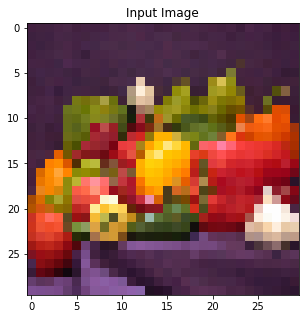

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:21<00:00, 41.20it/s]


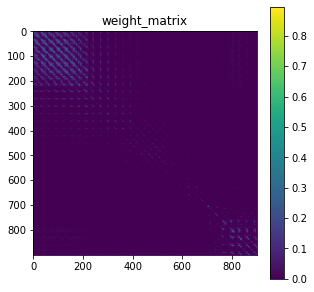

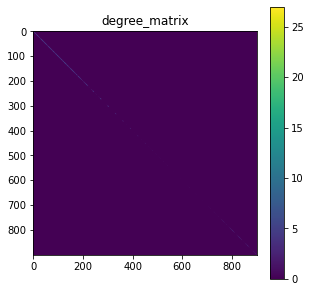

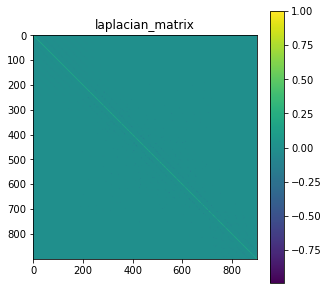

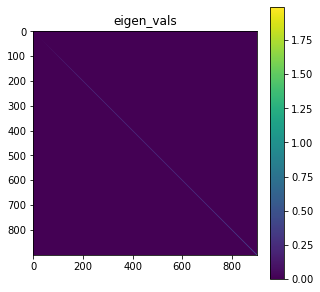

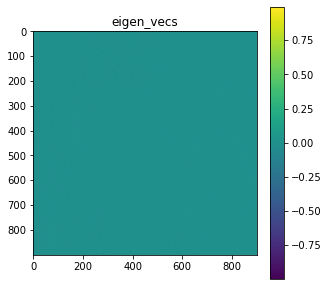

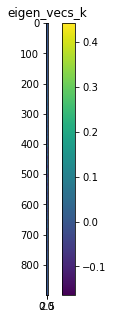

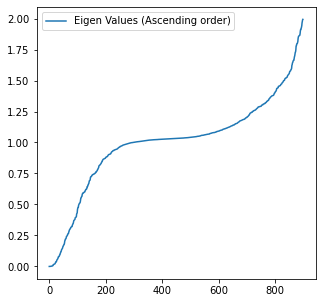

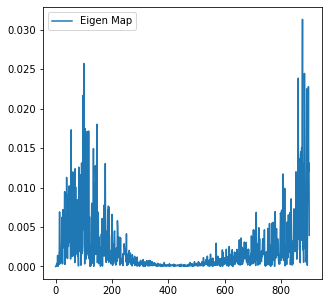

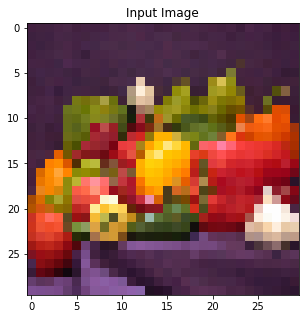

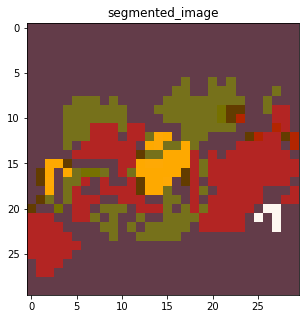

In [4]:
imshow(image, 'Input Image')

image_array = get_image_array(image)
weight_matrix = get_weight_matrix(image_array)
degree_matrix = get_degree_matrix(weight_matrix)
laplacian_matrix = get_laplacian_matrix(weight_matrix, degree_matrix)

eigen_vals, eigen_vecs = eigen_decompose(laplacian_matrix)
eigen_vecs_k = get_k_eigen_vectors(eigen_vecs)

visualize_matrix(weight_matrix, 'weight_matrix')
visualize_matrix(np.diag(degree_matrix), 'degree_matrix')
visualize_matrix(laplacian_matrix, 'laplacian_matrix')
visualize_matrix(np.diag(eigen_vals), 'eigen_vals')
visualize_matrix(eigen_vecs, 'eigen_vecs')
visualize_matrix(eigen_vecs_k, 'eigen_vecs_k')
plot_eigen_values(eigen_vals)
plot_eigen_map(eigen_vals)




kmeans = KMeans(n_clusters=args['num_clusters'], random_state=0).fit(eigen_vecs_k)
clustered_labels = kmeans.labels_
clustered_image = clustered_labels.reshape(args['height'], args['width'])

# segment the image using average color for each cluster
segmented_image = get_segmented_image(image, clustered_image, clustered_labels)

imshow(image, 'Input Image')
# imshow(clustered_image, 'Clustered Image')
imshow(segmented_image, 'segmented_image')